In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ephem
from category_encoders import TargetEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib


In [7]:

df = pd.read_excel("combined.xlsx")
df = df.drop(columns=["Unnamed: 3"], errors='ignore')
df = df.dropna(subset=["Percentagediff", "Date"])

# Create target
df['Target'] = df['Percentagediff'].apply(lambda x: 1 if x > 0 else 0)
target_label_map = {0: 'Negative', 1: 'Positive'}

# Date features
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek
print(df.describe())

                                Date          Open          High  \
count                           2467   2467.000000   2467.000000   
mean   2020-03-28 22:45:52.168625664  13857.797629  13921.294366   
min              2015-03-23 00:00:00   7023.650000   7034.200000   
25%              2017-09-25 12:00:00   9744.950000   9829.250000   
50%              2020-04-03 00:00:00  11681.000000  11749.850000   
75%              2022-09-27 12:00:00  17766.950000  17824.725000   
max              2025-03-28 00:00:00  26248.250000  26277.350000   
std                              NaN   5125.562400   5144.953899   

                Low         Close        Volume          RSI   Pointsdiff  \
count   2467.000000   2467.000000  2.467000e+03  2460.000000  2467.000000   
mean   13771.215910  13847.984820  3.248344e+05    54.481378    -9.812809   
min     6825.800000   6970.600000  0.000000e+00    12.940000 -1295.000000   
25%     9697.250000   9770.000000  1.994500e+05    45.347500   -62.150000   
50

C:\Users\ANKITH\AppData\Local\Temp\ipykernel_18832\4165073602.py:10: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [8]:
# Lunar features
def moon_phase(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.phase

df['LunarPhase'] = df['Date'].apply(moon_phase)
df['NearFullMoon'] = (df['LunarPhase'] > 95).astype(int)
df['NearNewMoon'] = (df['LunarPhase'] < 5).astype(int)

# Categorical & interaction features
categorical_cols = ['Nakshatra', 'Tithi', 'Karna', 'Yoga']
df['Nak_Tithi'] = df['Nakshatra'].astype(str) + "_" + df['Tithi'].astype(str)
df['Yoga_Karna'] = df['Yoga'].astype(str) + "_" + df['Karna'].astype(str)
interaction_cols = ['Nak_Tithi', 'Yoga_Karna']
date_features = ['DayOfWeek']
moon_features = ['LunarPhase', 'NearFullMoon', 'NearNewMoon']

In [9]:
# Rolling statistics
df['RollingMean_3'] = df['Percentagediff'].rolling(window=3).mean()
df['RollingStd_3'] = df['Percentagediff'].rolling(window=3).std()

# Previous Day Change
df['PrevDayChange'] = df['Percentagediff'].shift(1)

# Group Target Mean Encoding
for col in categorical_cols:
    agg = df.groupby(col)['Target'].mean().rename(f"{col}_target_mean")
    df = df.merge(agg, on=col, how='left')

extra_features = ['RollingMean_3', 'RollingStd_3', 'PrevDayChange'] + [f"{col}_target_mean" for col in categorical_cols]
feature_cols = categorical_cols + interaction_cols + date_features + moon_features + extra_features

# Drop rows with NA after rolling and shifting
df = df.dropna(subset=feature_cols + ['Target'])

# Target encode categorical + interaction features
encoder = TargetEncoder(cols=categorical_cols + interaction_cols)
df[categorical_cols + interaction_cols] = encoder.fit_transform(df[categorical_cols + interaction_cols], df['Target'])



Fold 1 Accuracy: 78.95%


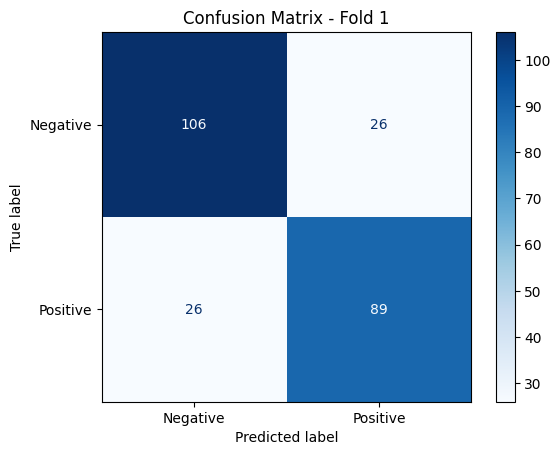


Fold 2 Accuracy: 82.59%


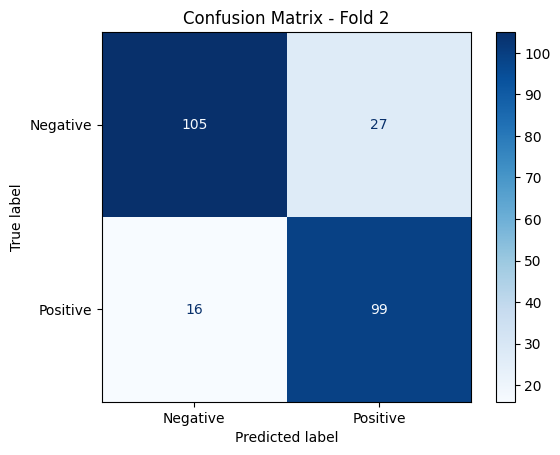


Fold 3 Accuracy: 76.52%


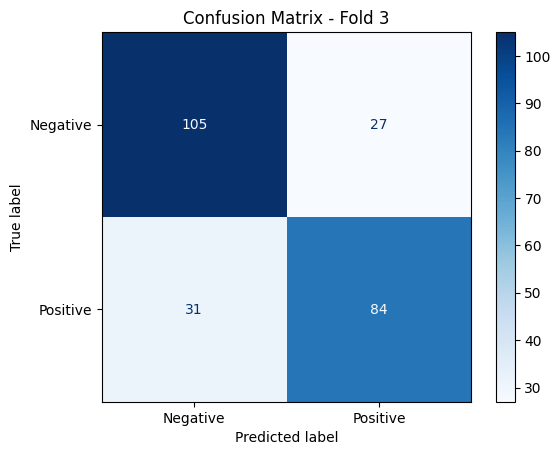


Fold 4 Accuracy: 82.19%


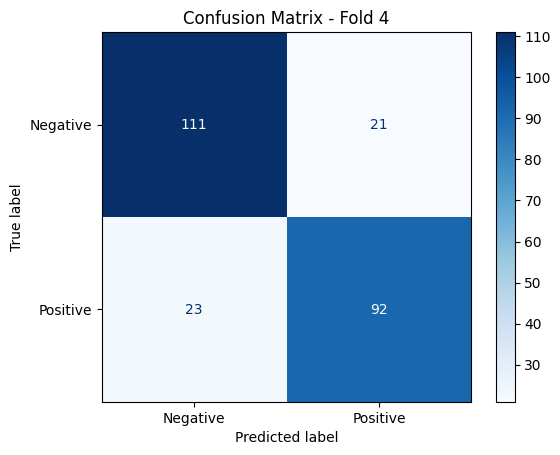


Fold 5 Accuracy: 80.97%


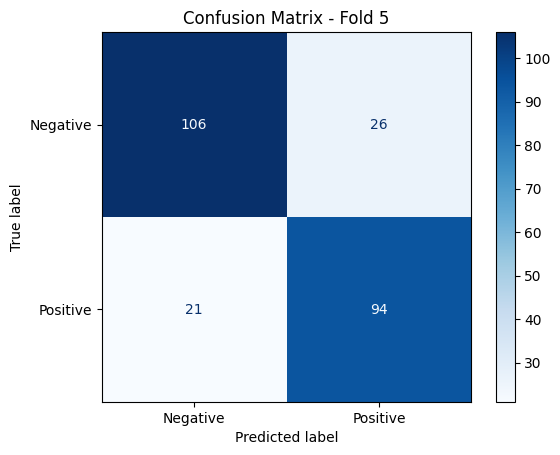


Fold 6 Accuracy: 82.11%


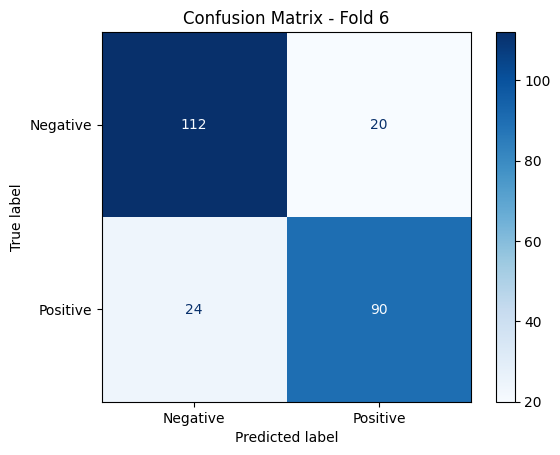


Fold 7 Accuracy: 78.05%


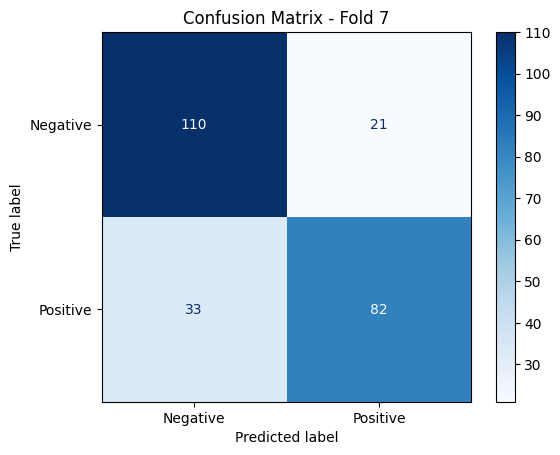


Fold 8 Accuracy: 81.71%


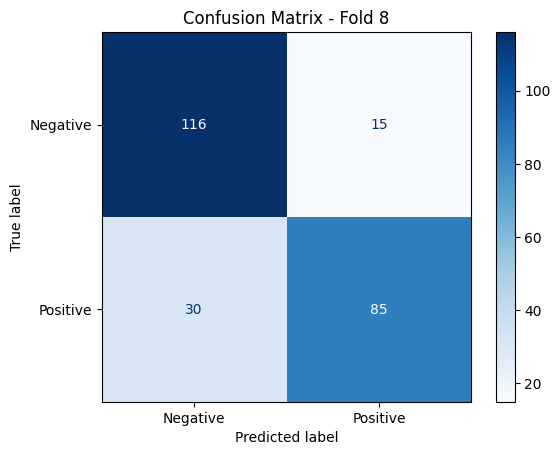


Fold 9 Accuracy: 75.20%


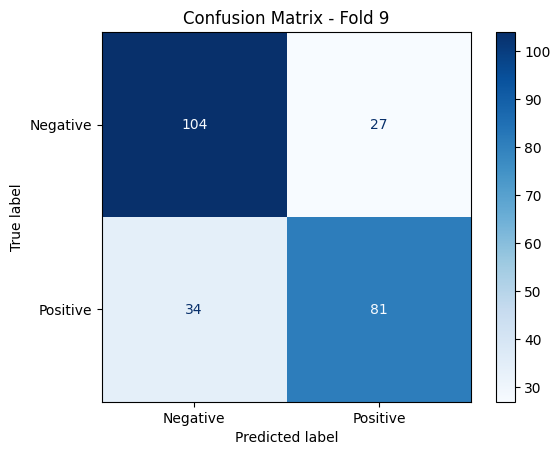


Fold 10 Accuracy: 76.83%


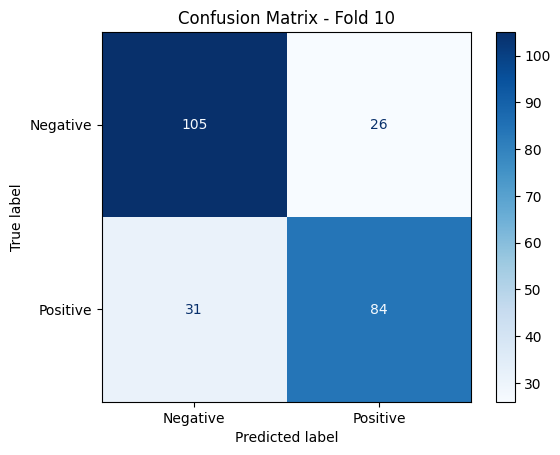


✅ Average Accuracy: 79.51%


In [10]:
X = df[feature_cols].values
y = df['Target'].values

# Stratified K-Fold CV
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    search = RandomizedSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_distributions=param_dist,
        n_iter=15,
        scoring='accuracy',
        cv=3,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train, y_train)
    model = search.best_estimator_

    acc = model.score(X_test, y_test)
    accuracies.append(acc)

    y_pred = model.predict(X_test)
    print(f"\nFold {fold} Accuracy: {acc * 100:.2f}%")
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=['Negative', 'Positive'], cmap='Blues')
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold}")
    plt.show()

print(f"\n✅ Average Accuracy: {np.mean(accuracies) * 100:.2f}%")


In [40]:
joblib.dump(model, "rf_model.pkl")

['rf_model.pkl']

In [19]:
user_input = {
    'Nakshatra': 'Mrigashira',
    'Tithi': 'Trayodashi',
    'Karna': 'Garaja',
    'Yoga': 'Dhruva',
    'Date': '2025-07-22',
    'Percentagediff': 0  
}

In [20]:
user_input['Nak_Tithi'] = f"{user_input['Nakshatra']}_{user_input['Tithi']}"
user_input['Yoga_Karna'] = f"{user_input['Yoga']}_{user_input['Karna']}"
user_input['Date'] = pd.to_datetime(user_input['Date'])
user_input['DayOfWeek'] = user_input['Date'].dayofweek
user_input['LunarPhase'] = moon_phase(user_input['Date'])
user_input['NearFullMoon'] = int(user_input['LunarPhase'] > 95)
user_input['NearNewMoon'] = int(user_input['LunarPhase'] < 5)

In [21]:
user_df = pd.DataFrame([user_input])
user_df[categorical_cols + interaction_cols] = encoder.transform(user_df[categorical_cols + interaction_cols])

# Fill NAs
for col in extra_features:
    median_val = df[col].median()
    user_df[col] = median_val

In [22]:
user_encoded = user_df[feature_cols]
prediction = model.predict(user_encoded.values)[0]
label = target_label_map[int(prediction)]

print(f"\n📌 Prediction for input ({user_input['Nakshatra']}, {user_input['Tithi']}, {user_input['Karna']}, {user_input['Yoga']}): **{label}**")


📌 Prediction for input (Mrigashira, Trayodashi, Garaja, Dhruva): **Negative**


NameError: name 'df' is not defined